# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) N % 5
2) N^2 % 5 + 5 


где $N$ - номер в списке

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../datasets/students_simple.csv')

N = 19
col1 = N % 5
col2 = (N**2) % 5 + 5

x = df.iloc[:, col1].dropna()
y = df.iloc[:, col2].dropna()

common_idx = x.index.intersection(y.index)
x = x.loc[common_idx]
y = y.loc[common_idx]

print(f"Размер выборки: {len(x)}")
print(f"Столбец 1: {df.columns[col1]}")
print(f"Столбец 2: {df.columns[col2]}")

Размер выборки: 20
Столбец 1: pages
Столбец 2: bmi


## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

### 1) [Коэффициент Фехнера](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_basic_statistics_fechner_correlation.pdf)

**Идея и формула.**
Коэффициент Фехнера основан на сравнении знаков отклонений каждого наблюдения от соответствующих средних. Для каждой записи i берем знаки `sign(x_i - x̄)` и `sign(y_i - ȳ)`. Обозначим

* $N_{+}$ - число наблюдений, где знаки совпадают (обе положительные или обе отрицательные),
* $N_{-}$ - число наблюдений, где знаки противоположны.

Тогда коэффициент Фехнера:

$F = \frac{N_{+} - N_{-}}{N_{+} + N_{-}}$

Диапазон: от −1 до +1. (Если все сравнения дают одинаковый знак → F = 1; противоположные - F = −1.)

Нули могут искажать счет, поэтому есть смысл их убрать.

Это непараметрическая мера согласованности направлений отклонений; она хорошо показывает, насколько данные "двигаются" в одно направление относительно своих средних.

### 2) [Пирсон + доверительный интервал](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0)

Коэффициент корреляции Пирсона измеряет линейную взаимосвязь между двумя количественными переменными 𝑋 и 𝑌. Идея: оценить, насколько отклонения 𝑋 от своего среднего совпадают с отклонениями 𝑌 от своего среднего.

**Формула Пирсона:**

$
r = \frac{\sum_{i=1}^n (x_i - \bar x)(y_i - \bar y)}
{\sqrt{\sum_{i=1}^n (x_i - \bar x)^2};\sqrt{\sum_{i=1}^n (y_i - \bar y)^2}}.
$

Числитель - ковариация.
Знаменатель - произведение стандартных отклонений

Интерпретация: −1 (полная отрицательная линейная связь) … 0 (нет линейной) … +1 (полная положительная линейная).

**p-value:** проверка ($H_0: \rho=0$ (в генеральной совокупности нет линейной связи)) через t-статистику:
$
t = r\sqrt{\frac{n-2}{1-r^2}},
$
с распределением (t) с (n-2) степенями свободы.

**Доверительный интервал для r**
Проблема: распределение r несимметрично при r близких к ±1. Поэтому применяют преобразование Фишера:

$
z = \operatorname{arctanh}(r) = \tfrac{1}{2}\ln\frac{1+r}{1-r}.
$

$
z \pm z_{1-\alpha/2}\cdot \frac{1}{\sqrt{n-3}}.
$
z1−α/2 - квантиль стандартного нормального.

Потом обратное преобразование: ($r = \tanh(z)$).

-  Пирсон оценивает **линейную** связь и чувствителен к выбросам; для немонотонных зависимостей он может давать близкое к нулю значение даже при сильной связи.

### 3) [Спирмен](https://wiki.loginom.ru/articles/rank-correlation-spearman.html)

Спирмен - это коэффициент корреляции рангов. 
Проще всего думать так: замените исходные значения на их ранги по каждому признаку, а потом посчитайте корреляцию Пирсона между рангами. Если нет повторяющихся значений, существует простая формула
$
\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)},
$
где ($d_i$) - разность рангов для i-го наблюдения. Spearman оценивает **монотоническую** связь (не обязательно линейную).

### 4) [Кенделл](https://wiki.loginom.ru/articles/rank-correlation-kendall.html)

Основан на понятии *конкордантных* и *дисконкордантных* пар. Для всех пар (i<j) считаем:

* пара Concordant, если порядок по x совпадает с порядком по y (оба увеличиваются или уменьшаются),
* Discordant, если порядок противоположный.

Без учета ничьих:
$
\tau = \frac{n_c - n_d}{{n \choose 2}},
$
где $(n_c)$ - число конкорд., $(n_d)$ - число дисконкорд.
Есть несколько вариантов $(τ_a, τ_b, τ_c)$ - $τ_b$ корректирует влияние связанных рангов (ties). 

Kendall более «консервативен», чем Spearman; хорошо работает на небольших выборках и при наличии связей.

In [11]:
import math
import numpy as np

def fechner_correlation(x, y):
    """
    реализация корреляции Фехнера
    """
    # Вычисляем средние значения для обеих переменных
    x_mean = np.mean(x)  # среднее первой переменной
    y_mean = np.mean(y)  # среднее второй переменной
    
    n = len(x)  # размер выборки
    concordant = 0  # счетчик совпадающих знаков
    discordant = 0  # счетчик противоположных знаков
    
    # Проверяем каждое наблюдение
    for i in range(n):
        # Определяем знак отклонения от среднего для x
        x_sign = 1 if x[i] > x_mean else (-1 if x[i] < x_mean else 0)
        # Определяем знак отклонения от среднего для y
        y_sign = 1 if y[i] > y_mean else (-1 if y[i] < y_mean else 0)
        
        # Если знаки одинаковые - увеличиваем concordant
        if x_sign * y_sign > 0:
            concordant += 1
        # Если знаки противоположные - увеличиваем discordant
        elif x_sign * y_sign < 0:
            discordant += 1
    
    # Общее количество пар с ненулевыми знаками
    total_pairs = concordant + discordant
    if total_pairs == 0:
        return 0
    
    # Формула Фехнера: (совпадающие - противоположные) / общее количество
    return (concordant - discordant) / total_pairs

def pearson_correlation(x, y):
    """
    реализация корреляции Пирсона с доверительным интервалом
    """
    n = len(x)  # размер выборки
    
    # Вычисляем средние значения
    x_mean = np.mean(x)  # среднее x
    y_mean = np.mean(y)  # среднее y
    
    # Инициализируем переменные для сумм
    covariance = 0  # ковариация (числитель формулы Пирсона)
    var_x = 0      # дисперсия x (часть знаменателя)
    var_y = 0      # дисперсия y (часть знаменателя)
    
    # Вычисляем суммы для формулы Пирсона
    for i in range(n):
        dx = x[i] - x_mean  # отклонение x от среднего
        dy = y[i] - y_mean  # отклонение y от среднего
        covariance += dx * dy  # накапливаем ковариацию
        var_x += dx * dx       # накапливаем дисперсию x
        var_y += dy * dy       # накапливаем дисперсию y
    
    # Вычисляем коэффициент корреляции Пирсона
    if var_x == 0 or var_y == 0:
        r = 0  # если нет вариации - корреляция 0
    else:
        r = covariance / math.sqrt(var_x * var_y)  # формула Пирсона
    
    # Доверительный интервал с использованием z-преобразования Фишера
    if abs(r) < 0.999 and n > 3:
        # z-преобразование Фишера для симметризации распределения
        z = 0.5 * math.log((1 + r) / (1 - r))
        
        # Стандартная ошибка z
        se = 1 / math.sqrt(n - 3)
        
        # Доверительный интервал для z (95%)
        z_lower = z - 1.96 * se  # нижняя граница
        z_upper = z + 1.96 * se  # верхняя граница
        
        # Обратное преобразование к коэффициенту корреляции
        r_lower = (math.exp(2 * z_lower) - 1) / (math.exp(2 * z_lower) + 1)
        r_upper = (math.exp(2 * z_upper) - 1) / (math.exp(2 * z_upper) + 1)
    else:
        r_lower, r_upper = r, r  # если r близок к ±1
    
    return r, (r_lower, r_upper)

def spearman_correlation(x, y):
    """
    реализация корреляции Спирмена
    """
    n = len(x)  # размер выборки
    
    # Функция для вычисления рангов с учетом связей
    def get_ranks(data):
        sorted_data = sorted(data)  # сортируем данные
        ranks = []
        for value in data:
            # Находим все позиции с таким значением (для учета связей)
            positions = [i for i, v in enumerate(sorted_data) if v == value]
            # Средний ранг для связанных значений
            rank = sum(positions) / len(positions) + 1
            ranks.append(rank)
        return ranks
    
    # Получаем ранги для обеих переменных
    ranks_x = get_ranks(x)  # ранги x
    ranks_y = get_ranks(y)  # ранги y
    
    # Вычисляем сумму квадратов разностей рангов
    d_squared_sum = 0
    for i in range(n):
        d = ranks_x[i] - ranks_y[i]  # разность рангов
        d_squared_sum += d * d      # квадрат разности
    
    # Корреляция Спирмена по формуле
    if n <= 1:
        return 0
    
    # Формула Спирмена: 1 - (6 * сумма квадратов разностей) / (n * (n² - 1))
    rho = 1 - (6 * d_squared_sum) / (n * (n * n - 1))
    return rho

def kendall_correlation(x, y):
    """
    реализация корреляции Кендалла
    """
    n = len(x)  # размер выборки
    
    concordant = 0  # счетчик конкордантных пар (одинаковый порядок)
    discordant = 0  # счетчик дискордантных пар (противоположный порядок)
    
    # Проверяем все пары (i, j) где i < j
    for i in range(n):
        for j in range(i + 1, n):
            x_diff = x[i] - x[j]  # разность x
            y_diff = y[i] - y[j]  # разность y
            
            product = x_diff * y_diff  # произведение разностей
            
            if product > 0:
                concordant += 1   # одинаковое направление изменения
            elif product < 0:
                discordant += 1  # противоположное направление
    
    # Общее количество пар
    total_pairs = concordant + discordant
    if total_pairs == 0:
        return 0
    
    # Формула Кендалла: (конкордантные - дискордантные) / общее количество
    tau = (concordant - discordant) / total_pairs
    return tau

# Тестирование функций
print("Реализации корреляций:")

# Вычисляем все виды корреляций
fechner_manual = fechner_correlation(x, y)  # корреляция Фехнера
pearson_manual, pearson_ci_manual = pearson_correlation(x, y)  # Пирсон + доверительный интервал
spearman_manual = spearman_correlation(x, y)  # корреляция Спирмена
kendall_manual = kendall_correlation(x, y)  # корреляция Кендалла

print(f"Фехнер: {fechner_manual:.4f}")
print(f"Пирсон: {pearson_manual:.4f}")
print(f"Доверительный интервал Пирсона: ({pearson_ci_manual[0]:.4f}, {pearson_ci_manual[1]:.4f})")
print(f"Спирмен: {spearman_manual:.4f}")
print(f"Кендалл: {kendall_manual:.4f}")
    

Реализации корреляций:
Фехнер: -0.4000
Пирсон: -0.1795
Доверительный интервал Пирсона: (-0.5763, 0.2857)
Спирмен: -0.3000
Кендалл: -0.2638


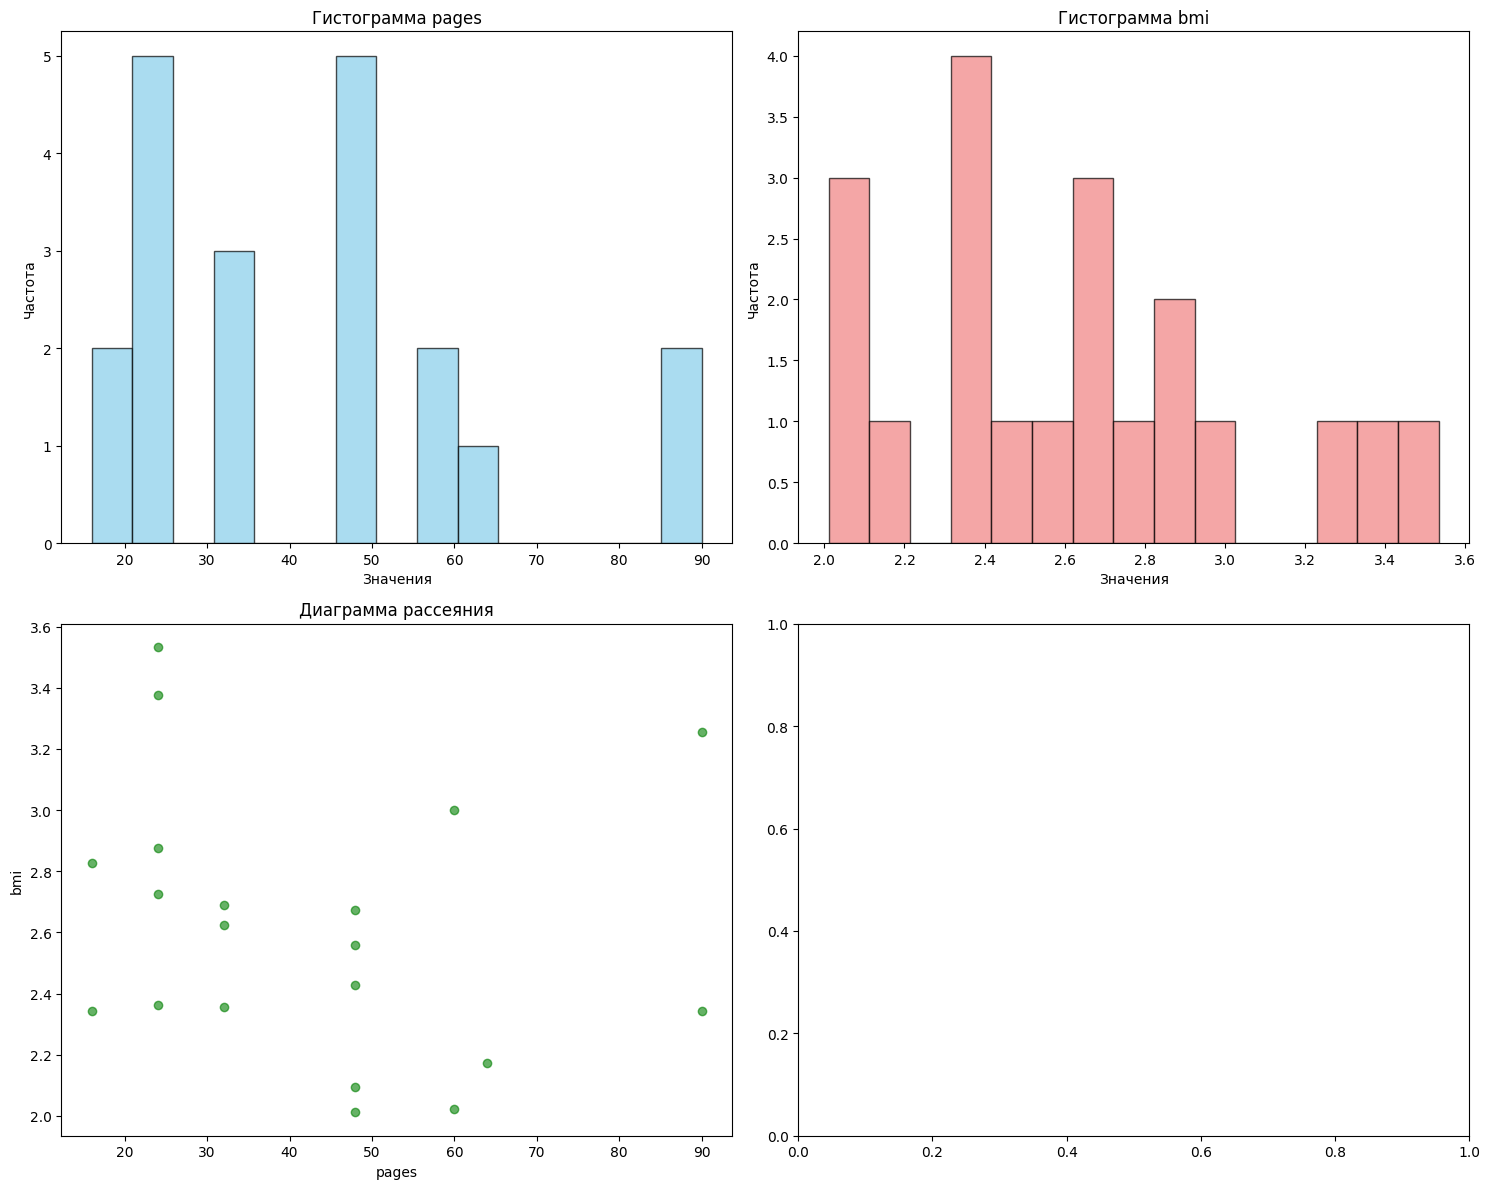


Основные статистики:
X (pages):
  Среднее: 42.60, Медиана: 40.00, STD: 21.43
Y (bmi):
  Среднее: 2.61, Медиана: 2.59, STD: 0.43


In [12]:
# Создание графиков для визуализации данных
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # сетка 2x2 для графиков

# Гистограмма переменной X (первая переменная)
axes[0, 0].hist(x, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'Гистограмма {df.columns[col1]}')  # заголовок с названием столбца
axes[0, 0].set_xlabel('Значения')  # подпись оси X
axes[0, 0].set_ylabel('Частота')   # подпись оси Y

# Гистограмма переменной Y (вторая переменная)
axes[0, 1].hist(y, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title(f'Гистограмма {df.columns[col2]}')  # заголовок с названием столбца
axes[0, 1].set_xlabel('Значения')  # подпись оси X
axes[0, 1].set_ylabel('Частота')   # подпись оси Y

# Диаграмма рассеяния (scatter plot) - связь между переменными
axes[1, 0].scatter(x, y, alpha=0.6, color='green')  # точки с прозрачностью
axes[1, 0].set_title('Диаграмма рассеяния')  # заголовок
axes[1, 0].set_xlabel(f'{df.columns[col1]}')  # подпись оси X
axes[1, 0].set_ylabel(f'{df.columns[col2]}')  # подпись оси Y

plt.tight_layout()  # автоматическая настройка расстояний между графиками
plt.show()  # отображение графиков

# Дополнительная информация о данных - основные статистики
print("\nОсновные статистики:")
print(f"X ({df.columns[col1]}):")
print(f"  Среднее: {np.mean(x):.2f}, Медиана: {np.median(x):.2f}, STD: {np.std(x):.2f}")
print(f"Y ({df.columns[col2]}):")
print(f"  Среднее: {np.mean(y):.2f}, Медиана: {np.median(y):.2f}, STD: {np.std(y):.2f}")

## 3. Уравнение регрессии

Регрессия - это способ построить модель, которая предсказывает зависимую переменную (y) через одну или несколько независимых переменных (x). Мы ищем функцию $(f(x; \mathbf{w}))$ с параметрами $(\mathbf{w})$, которая лучше всего объясняет наблюдаемые данные $((x_i,y_i))$.

* минимизируем сумму квадратов ошибок (OLS - ordinary least squares): $(\min_{\mathbf w}\sum_i (y_i - f(x_i;\mathbf w))^2)$.
* Результат - набор коэффициентов. Они дают формулу регрессии, по которой можно предсказывать (y) для новых (x).


Построить уравнение регрессии по видам:

1. **Линейная** $(y = w_1 x + w_0)$
   самая простая; сводится к линейной регрессии по параметрам ($w_1,w_0$).
   Минимизируем $(\sum (y_i - w_1 x_i - w_0)^2)$

2. **Квадратичная** $(y = w_2 x^2 + w_1 x + w_0)$
   Тоже линейная по параметрам (w_2,w_1,w_0)

3. **Гиперболическая** $(y = \dfrac{w_1}{x} + w_0)$
   модель линейна по параметрам, если ввести новый признак $(z = 1/x)$: тогда $(y = w_1 z + w_0)$. Поэтому подгонка - обычный OLS, но надо удалить или обработать точки с (x=0) (деление на ноль).

4. **Показательная** $(y = w_0 \cdot w_1^x)$
   Преобразование логарифмированием дает линейную форму:
   $
   \ln y = \ln w_0 + x \ln w_1.
   $
   Значит подгонка: сначала оставить только (y>0), взять $(Y=\ln y)$ и выполнить линейную регрессию $(Y = c_0 + c_1 x)$. Затем $(w_0 = e^{c_0},\ w_1 = e^{c_1})$

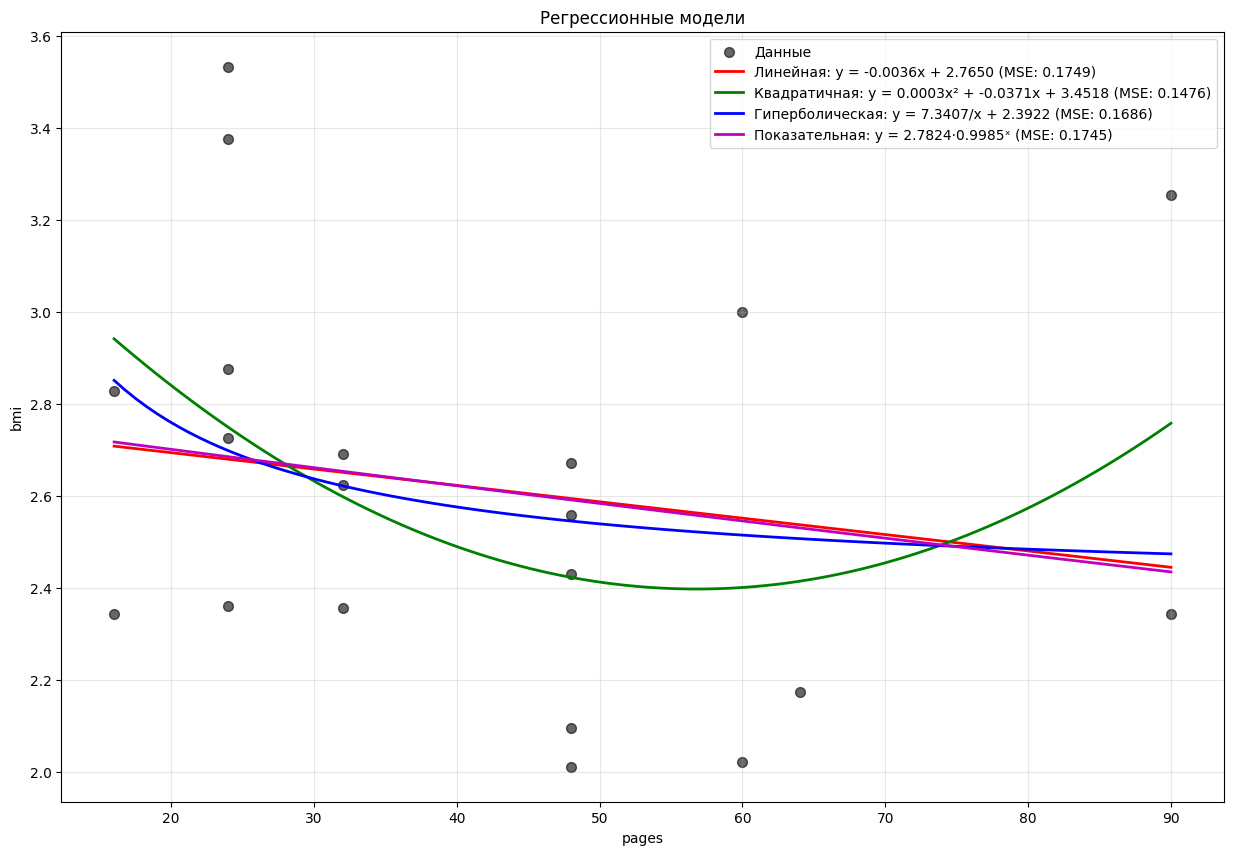


Сравнение моделей (по MSE):
  Квадратичная: 0.1476
  Гиперболическая: 0.1686
  Показательная: 0.1745
  Линейная: 0.1749
Лучшая модель: Квадратичная
Худшая модель: Линейная


In [13]:
# Определение функций для регрессии
def linear_func(x, w1, w0):
    """Линейная функция: y = w1*x + w0"""
    return w1 * x + w0

def quadratic_func(x, w2, w1, w0):
    """Квадратичная функция: y = w2*x² + w1*x + w0"""
    return w2 * x**2 + w1 * x + w0

def hyperbolic_func(x, w1, w0):
    """Гиперболическая функция: y = w1/x + w0"""
    return w1 / x + w0

def exponential_func(x, w1, w0):
    """Показательная функция: y = w0 * w1^x"""
    return w0 * (w1 ** x)

# Подгонка моделей с обработкой ошибок
try:
    # Подгонка линейной модели методом наименьших квадратов
    popt_linear, pcov_linear = curve_fit(linear_func, x, y)
    y_pred_linear = linear_func(x, *popt_linear)  # предсказания линейной модели
    mse_linear = np.mean((y - y_pred_linear)**2)  # средняя квадратичная ошибка
except:
    mse_linear = float('inf')  # если подгонка не удалась

try:
    # Подгонка квадратичной модели
    popt_quad, pcov_quad = curve_fit(quadratic_func, x, y)
    y_pred_quad = quadratic_func(x, *popt_quad)  # предсказания квадратичной модели
    mse_quad = np.mean((y - y_pred_quad)**2)    # средняя квадратичная ошибка
except:
    mse_quad = float('inf')  # если подгонка не удалась

try:
    # Подгонка гиперболической модели
    popt_hyp, pcov_hyp = curve_fit(hyperbolic_func, x, y)
    y_pred_hyp = hyperbolic_func(x, *popt_hyp)  # предсказания гиперболической модели
    mse_hyp = np.mean((y - y_pred_hyp)**2)      # средняя квадратичная ошибка
except:
    mse_hyp = float('inf')  # если подгонка не удалась

try:
    # Подгонка показательной модели (увеличиваем лимит итераций)
    popt_exp, pcov_exp = curve_fit(exponential_func, x, y, maxfev=5000)
    y_pred_exp = exponential_func(x, *popt_exp)  # предсказания показательной модели
    mse_exp = np.mean((y - y_pred_exp)**2)       # средняя квадратичная ошибка
except:
    mse_exp = float('inf')  # если подгонка не удалась

# Создание графика с регрессионными моделями
plt.figure(figsize=(15, 10))

# Исходные данные - точки наблюдений
plt.scatter(x, y, alpha=0.6, color='black', label='Данные', s=50)

# Сортировка для плавных линий регрессии
x_sorted = np.sort(x)  # сортированные значения x
x_cont = np.linspace(x.min(), x.max(), 100)  # непрерывная сетка для построения кривых

# Линейная регрессия
if mse_linear != float('inf'):
    y_linear = linear_func(x_cont, *popt_linear)  # значения линейной функции на сетке
    plt.plot(x_cont, y_linear, 'r-', linewidth=2, 
             label=f'Линейная: y = {popt_linear[0]:.4f}x + {popt_linear[1]:.4f} (MSE: {mse_linear:.4f})')

# Квадратичная регрессия
if mse_quad != float('inf'):
    y_quad = quadratic_func(x_cont, *popt_quad)  # значения квадратичной функции на сетке
    plt.plot(x_cont, y_quad, 'g-', linewidth=2, 
             label=f'Квадратичная: y = {popt_quad[0]:.4f}x² + {popt_quad[1]:.4f}x + {popt_quad[2]:.4f} (MSE: {mse_quad:.4f})')

# Гиперболическая регрессия
if mse_hyp != float('inf'):
    y_hyp = hyperbolic_func(x_cont, *popt_hyp)  # значения гиперболической функции на сетке
    plt.plot(x_cont, y_hyp, 'b-', linewidth=2, 
             label=f'Гиперболическая: y = {popt_hyp[0]:.4f}/x + {popt_hyp[1]:.4f} (MSE: {mse_hyp:.4f})')

# Показательная регрессия
if mse_exp != float('inf'):
    y_exp = exponential_func(x_cont, *popt_exp)  # значения показательной функции на сетке
    plt.plot(x_cont, y_exp, 'm-', linewidth=2, 
             label=f'Показательная: y = {popt_exp[1]:.4f}·{popt_exp[0]:.4f}ˣ (MSE: {mse_exp:.4f})')

# Настройка графика
plt.xlabel(f'{df.columns[col1]}')  # подпись оси X
plt.ylabel(f'{df.columns[col2]}')  # подпись оси Y
plt.title('Регрессионные модели')  # заголовок
plt.legend()  # легенда с моделями
plt.grid(True, alpha=0.3)  # сетка для удобства чтения
plt.show()  # отображение графика

# Сравнение моделей по качеству (MSE - чем меньше, тем лучше)
models = {
    'Линейная': mse_linear,
    'Квадратичная': mse_quad,
    'Гиперболическая': mse_hyp,
    'Показательная': mse_exp
}

# Фильтруем только успешно подогнанные модели
valid_models = {k: v for k, v in models.items() if v != float('inf')}
if valid_models:
    # Находим лучшую и худшую модели по MSE
    best_model = min(valid_models, key=valid_models.get)  # минимальная MSE
    worst_model = max(valid_models, key=valid_models.get)  # максимальная MSE
    
    print(f"\nСравнение моделей (по MSE):")
    # Сортируем модели по качеству (от лучшей к худшей)
    for model, mse in sorted(valid_models.items(), key=lambda x: x[1]):
        print(f"  {model}: {mse:.4f}")
    print(f"Лучшая модель: {best_model}")
    print(f"Худшая модель: {worst_model}")

по каждой из кривых видно что они не могут нормально уловить зависимость в данных так как они(точки) имеют очень сильных разброс

### [Фишер](https://en.wikipedia.org/wiki/F-test) 

Для наилучшего и наихудшего уравнения регрессии проверить соотвествие модели данных с помощью критерия Фишера.


Объясняет ли наша модель зависимость y лучше, чем просто усредненное значение $(\bar y)$?

* Нулевая гипотеза (H_0): модель не лучше, чем константа
* Альтернатива (H_1): модель объясняет значительную часть вариации y

F-тест сравнивает **объясненную дисперсию** (насколько модель сдвигает предсказания от среднего) с **необъясненной (остаточной) дисперсией**. Если отношение (корректированное на число параметров) велико - модель значима.


Обозначения:

* (n) — число наблюдений (в модели, на которых проводили подгонку).
* (k) — число параметров модели (включая свободный член). Примеры: линейная (k=2) (w1, w0), квадратичная (k=3), и т.д.
* $(y_i)$ — наблюдаемое значение,
* $(\hat y_i)$ — предсказанное моделью,
* $(\bar y = \frac{1}{n}\sum_i y_i)$.

Суммы квадратов:

* $(SS_{tot} = \sum_{i=1}^n (y_i - \bar y)^2)$ — полная сумма квадратов (общая вариация).
* $(SS_{res} = \sum_{i=1}^n (y_i - \hat y_i)^2)$ — остаточная сумма квадратов (необъясненная вариация).
* $(SS_{reg} = SS_{tot} - SS_{res} = \sum (\hat y_i - \bar y)^2)$ — объясненная моделью вариация.

Степени свободы:

* $(df_{reg} = k - 1)$
* $(df_{res} = n - k)$

F-статистика:
$
F = \frac{SS_{reg} / df_{reg}}{SS_{res} / df_{res}}.
$

Если (H_0) истинна, то (F) имеет распределение $(F(df_{reg}, df_{res}))$. Мы сравниваем наблюдаемое (F) с критическим значением $(F_{crit})$ при заданном $(\alpha)$ (обычно 0.05), или вычисляем p-value: $(p = 1 - F_{cdf}(F))$ (или `stats.f.sf(F, df_reg, df_res)` в scipy).

Крайние случаи:

* Если $(SS_{res} = 0) $(идеальная подгонка) → $(F=\infty)$ и p≈0 — модель "полностью" объясняет y.
* Если $(SS_{tot} = 0)$ (все y равны) → тест не определен (нет вариации).

In [14]:
def fisher_test(y_true, y_pred, k, alpha=0.05):
    """
    критерий Фишера для проверки адекватности регрессионной модели
    проверяет, лучше ли модель объясняет данные, чем простое среднее
    """
    n = len(y_true)  # размер выборки
    
    # Вычисляем суммы квадратов для F-статистики
    ss_residual = np.sum((y_true - y_pred)**2)  # остаточная сумма квадратов (необъясненная вариация)
    ss_total = np.sum((y_true - np.mean(y_true))**2)  # общая сумма квадратов (полная вариация)
    ss_regression = ss_total - ss_residual  # объясненная моделью вариация
    
    # Степени свободы для F-распределения
    df_regression = k - 1  # степени свободы для регрессии (количество параметров - 1)
    df_residual = n - k    # степени свободы для остатков (размер выборки - количество параметров)
    
    # Проверяем корректность степеней свободы
    if df_residual <= 0 or df_regression <= 0:
        return None, None, None
    
    # Средние квадраты (дисперсии)
    ms_regression = ss_regression / df_regression  # средний квадрат регрессии
    ms_residual = ss_residual / df_residual       # средний квадрат остатков
    
    # F-статистика: отношение объясненной дисперсии к необъясненной
    f_statistic = ms_regression / ms_residual if ms_residual != 0 else float('inf')
    
    # Критическое значение F для заданного уровня значимости
    f_critical = stats.f.ppf(1 - alpha, df_regression, df_residual)
    
    # Возвращаем F-статистику, критическое значение и результат теста
    return f_statistic, f_critical, f_statistic > f_critical

# Проверка критерием Фишера для лучшей и худшей моделей
print("\nПроверка критерием Фишера:")

# Определяем предсказания и количество параметров для лучшей модели
if best_model == 'Линейная':
    y_pred_best = y_pred_linear  # предсказания линейной модели
    k_best = 2  # количество параметров (w1, w0)
elif best_model == 'Квадратичная':
    y_pred_best = y_pred_quad    # предсказания квадратичной модели
    k_best = 3  # количество параметров (w2, w1, w0)
elif best_model == 'Гиперболическая':
    y_pred_best = y_pred_hyp     # предсказания гиперболической модели
    k_best = 2  # количество параметров (w1, w0)
elif best_model == 'Показательная':
    y_pred_best = y_pred_exp     # предсказания показательной модели
    k_best = 2  # количество параметров (w1, w0)

# Применяем критерий Фишера к лучшей модели
f_stat_best, f_crit_best, adequate_best = fisher_test(y, y_pred_best, k_best)

print(f"\n{best_model} модель (лучшая):")
print(f"  F-статистика: {f_stat_best:.4f}")
print(f"  Критическое значение F: {f_crit_best:.4f}")
print(f"  Модель адекватна: {'Да' if adequate_best else 'Нет'}")

# Определяем предсказания и количество параметров для худшей модели
if worst_model == 'Линейная':
    y_pred_worst = y_pred_linear  # предсказания линейной модели
    k_worst = 2  # количество параметров (w1, w0)
elif worst_model == 'Квадратичная':
    y_pred_worst = y_pred_quad    # предсказания квадратичной модели
    k_worst = 3  # количество параметров (w2, w1, w0)
elif worst_model == 'Гиперболическая':
    y_pred_worst = y_pred_hyp     # предсказания гиперболической модели
    k_worst = 2  # количество параметров (w1, w0)
elif worst_model == 'Показательная':
    y_pred_worst = y_pred_exp     # предсказания показательной модели
    k_worst = 2  # количество параметров (w1, w0)

# Применяем критерий Фишера к худшей модели
f_stat_worst, f_crit_worst, adequate_worst = fisher_test(y, y_pred_worst, k_worst)

print(f"\n{worst_model} модель (худшая):")
print(f"  F-статистика: {f_stat_worst:.4f}")
print(f"  Критическое значение F: {f_crit_worst:.4f}")
print(f"  Модель адекватна: {'Да' if adequate_worst else 'Нет'}")


Проверка критерием Фишера:

Квадратичная модель (лучшая):
  F-статистика: 1.9036
  Критическое значение F: 3.5915
  Модель адекватна: Нет

Линейная модель (худшая):
  F-статистика: 0.5993
  Критическое значение F: 4.4139
  Модель адекватна: Нет
